# Problem Set 11.2: Simulating noisy gates and quantum error correction

Due on Monday, 08.07.2025

In [10]:
%pip install -e .
%pip install qutip
%pip install matplotlib



Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Obtaining file:///home/f73aeabd-6de4-471d-92a9-1ba552ae6153/Quantum_Error_Corrections
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for quantum_error_corrections (pyproject.toml) ... done
  Created wheel for quantum_error_corrections: filename=quantum_error_corrections-0.1.0-0.editable-py3-none-any.whl size=1498 sha256=2341eaff5a44a0136e8dbf01b90373cb25a9dc28daae5c2975f3d4683f014768
  Stored in directory: /tmp/pip-ephem-wheel-cache-kh0ifuto/wheels/1f/c2/04/5304920ba13a58c5bf5bcca17823bee045c299fa30cae4d9b3
Successfully built quantum_error_corrections
  Attempting uninstall: quantum_error_corrections
    Found existing installation: quantum_error_corrections 0.1.0
    Uninstalling quantum_err

In [21]:
from quantum_error_corrections import (
    I, X, Y, Z, H, S, T, CNOT,
    P0, P1,
    rotation_gate,
    U_N_qubits, U_one_gate, U_two_gates,
    rho, evolve, controlled_gate, projectors,
    apply_kraus,
    bit_flip_kraus,
    phase_flip_kraus,
    depolarizing_kraus,
    amplitude_damping_kraus,
    phase_damping_kraus,
) 

## Problem outline

In Problem Set 2, you developed a brute force classical simulator for quantum circuits. In this problem set, you will augment this simulator by including the possibility of noisy (non-unitary) channels to mimic real quantum computers. You will use this framework to study common quantum channels and simulate quantum error correction protocols.

In [ ]:
# load some useful modules

 # standard numerics and linear algebra libraries
import numpy as np  
import numpy.linalg as LA
import scipy.linalg as sciLA

# for making plots
import matplotlib.pyplot as plt

# measure runtimes
import time as time 

# sparse matrix functions
import scipy.sparse as sparse

# for interactive graphics
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

# avoid typing np.XY all the time
from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange, exp)

# for making Bloch sphere plots
from qutip import Bloch

%matplotlib inline

# Problem 1: Single qubit channels

We start by implementing common single-qubit channels and visualizing their action on the Bloch sphere. Compared to the purely unitary case, the state of the system is now described by a density matrix $|\psi\rangle\rightarrow \rho$, and unitary operations are replaced by general quantum channels $U\rightarrow \mathcal{E}(\rho)$. Hint: For setting up the density matrix of a pure state  $\rho = |\psi\rangle \langle \psi|$ the numpy function `np.outer(psi.conj(),psi)` might be helpful.

#### (a) Defining a channel

Generate an array of Kraus operators $M_i$ for the bit flip, phase flip and amplitude damping channel. See Problem Set 11.1 for definitions of the channels.

Write a function that takes as an input (1) a density matrix of a single qubit and (2) the list of Kraus operators defining the channels and returns the density matrix after the channel has been applied.

Test your functions by applying, e.g., the bit flip channel to the states $|0\rangle$ and $|+\rangle$.

In [11]:
import numpy as np
import qutip as qt

# Basis states
ket0 = np.array([1, 0], dtype=complex)
ket1 = np.array([0, 1], dtype=complex)

# |+> = (|0> + |1>) / sqrt(2)
ket_plus = (ket0 + ket1) / np.sqrt(2)

# Density matrices
rho0 = np.outer(ket0, ket0.conj())
rho_plus = np.outer(ket_plus, ket_plus.conj())

# Choose noise parameter
p = 0.3
gamma = 0.3

# Kraus operators
K_bitflip = bit_flip_kraus(p)
K_phaseflip = phase_flip_kraus(p)
K_ampdamp = amplitude_damping_kraus(gamma)

# Apply channels
rho0_bitflip = apply_kraus(rho0, K_bitflip)
rho_plus_bitflip = apply_kraus(rho_plus, K_bitflip)

print("=== Bit flip on |0><0| ===")
print(rho0_bitflip)

print("\n=== Bit flip on |+><+| ===")
print(rho_plus_bitflip)


=== Bit flip on |0><0| ===
[[0.7+0.j 0. +0.j]
 [0. +0.j 0.3+0.j]]

=== Bit flip on |+><+| ===
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


#### (b) Visualization on the Bloch sphere

Write a function that calculates the Bloch vector $\overrightarrow{r}=(r_X,r_Y,r_Z)$ (called $P$ in the lecture) for a given single qubit density matrix. On Problem Set 2, we calculated the Bloch vector for a pure state (so that formalism won't necessarily work here). For mixed states, one can calculate the Bloch vector element via the equation 
$$r_J = \mathrm{Tr}(\rho J),$$ 
where $J$ is either $X,Y,Z$ and $\mathrm{Tr}$ represents the trace of a matrix (see `np.trace`).

First, take a pure state (say, for example, $|\psi\rangle = |1\rangle$). Apply (separately) each of the three channels we defined earlier to this state. Plot the original state on the Bloch sphere, as well as the three states after applying the channels (i.e., one state with the phase flip, the other with the bit flip, the other with the amplitude damping). Play around with the parameters to see how the channels alter the state.

Second, sample some homogeneously distributed points on the surface of the Bloch sphere by generating random pure states. An easy way to do this is to sample 2-dimensional vectors of complex numbers with random Gaussian distributed real and imaginary parts. Don't forget to normalise your state after generating the random values!

Tip for random state generation: generate the real and complex part of state separately. You may find the function `np.random.normal(mu,sigma,dim)` to be useful here.

Apply the channels defined above (e.g., with $p=0.3$) to each of these random pure states. Calculate the resulting Bloch vectors and plot them (with the original Bloch vectors) on the Bloch sphere to see the "flow" in the Bloch sphere that each channel induces.

In [35]:
# Write your function rhoToBlochVec here which calculates the Bloch vector given a state rho.
import numpy as np

def rhoToBV(rho):
    """
    Convert a 2x2 density matrix rho into Bloch vector (rx, ry, rz)

    rj = Tr(rho * sigma_j)  where sigma_j are Pauli matrices X,Y,Z
    """


    rx = np.real(np.trace(rho @ X))
    ry = np.real(np.trace(rho @ Y))
    rz = np.real(np.trace(rho @ Z))

    return np.array([rx, ry, rz])
ket0 = np.array([1, 0], dtype=complex)
rho0 = np.outer(ket0, ket0.conj())

print(rhoToBV(rho0))



[0. 0. 1.]


Original Bloch: [ 0.  0. -1.]
After bit flip: [ 0.   0.  -0.4]
After phase flip: [ 0.  0. -1.]
After amplitude damping: [ 0.   0.  -0.4]


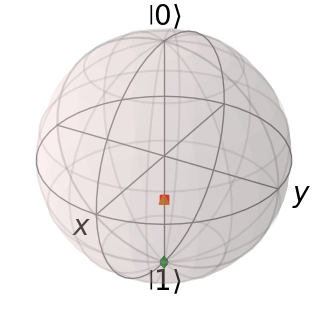

✅ Plotted: ['Original |1>', 'Bit flip', 'Phase flip', 'Amplitude damping']


In [31]:
# Call your blochVisualisation function here with different channels

import numpy as np
import qutip

def pure_density(psi):
    psi = np.array(psi, dtype=complex).reshape(-1)
    return np.outer(psi, np.conj(psi))

def rhoToBlochVec(rho):
    rx = np.real(np.trace(rho @ X))
    ry = np.real(np.trace(rho @ Y))
    rz = np.real(np.trace(rho @ Z))
    return np.array([rx, ry, rz])

def blochVisualisation(rho_list, labels=None, title="Bloch Sphere"):
    """
    rho_list = list of density matrices
    labels   = optional names
    """
    b = qutip.Bloch()
    b.figsize = [3, 3]
    b.title = title

    if labels is None:
        labels = [f"state {i}" for i in range(len(rho_list))]

    for rho, lab in zip(rho_list, labels):
        r = rhoToBlochVec(rho)  # (rx, ry, rz)

        # ✅ correct format for qutip: (3, N)
        b.add_points([[r[0]], [r[1]], [r[2]]], meth='s')

    b.render()
    b.show()
    print("✅ Plotted:", labels)

# ---- TEST ----
ket1 = np.array([0, 1], dtype=complex)
rho0 = pure_density(ket1)

p = 0.3
gamma = 0.3

rho_bit   = apply_kraus(rho0, bit_flip_kraus(p))
rho_phase = apply_kraus(rho0, phase_flip_kraus(p))
rho_amp   = apply_kraus(rho0, amplitude_damping_kraus(gamma))

print("Original Bloch:", r0)
print("After bit flip:", r_bit)
print("After phase flip:", r_phase)
print("After amplitude damping:", r_amp)



blochVisualisation(
    [rho0, rho_bit, rho_phase, rho_amp],
    labels=["Original |1>", "Bit flip", "Phase flip", "Amplitude damping"],
    title="Noise channels on Bloch sphere"
)

### Problem 2: Channels on a register

Similar to Q3 on Problem Set 2, we will now consider single qubit channels which act on qubits that are part of a register. 

#### (a) Single qubit channels in an n-bit register

Build Kraus operators for a given channel that act on qubit $i$ within a register of $n$ qubits. The unitary single qubit gates considered on Problem Set 2 are a subclass of these.

Use Kronecker products and sparse matrices as we did on Problem Set 2.

Hints: Recall that that if we want to apply a single qubit gate in this formalism, we can do so in the same way we apply the Kraus operators, e.g., if we want to apply a Hadamard gate, the channel would be 
$$\mathcal{E}(\rho) = H\rho H^\dagger.$$

Build your single quubit channel acting on the n-qubit register by creating a list of single qubit gates acting on the n-qubit register. That is, create the single qubit Kraus operators acting on the n-qubit register, then use these to create the channel.

Test your function on a few states where we already know the result, e.g., apply the Hadamard *channel* to the $|0\rangle$ state. 

In [34]:
import numpy as np

# ----------------------------
# Helper: computational basis |k>
# ----------------------------
def basisvec(n, k):
    v = np.zeros(2**n, dtype=complex)
    v[k] = 1
    return v


# ----------------------------
# Helper: density matrix from statevector
# rho = |psi><psi|
# ----------------------------
def pure_density(psi):
    psi = np.array(psi, dtype=complex).reshape(-1)
    return np.outer(psi, np.conj(psi))


# ----------------------------
# Build operator acting on n-qubit register
# Apply op on qubit i (0 = leftmost)
# ----------------------------
def embed_single_qubit_operator(op, n, i):
    I2 = np.eye(2, dtype=complex)
    ops = []

    for q in range(n):
        if q == i:
            ops.append(op)
        else:
            ops.append(I2)

    full_op = ops[0]
    for j in range(1, n):
        full_op = np.kron(full_op, ops[j])

    return full_op


# ----------------------------
# Build Kraus operators on n-qubit register
# Given single-qubit kraus_ops acting on qubit i
# ----------------------------
def kraus_on_register(kraus_ops, n, i):
    return [embed_single_qubit_operator(E, n, i) for E in kraus_ops]


# ----------------------------
# Example single-qubit unitary channel: Hadamard
# Channel: rho -> H rho H†
# Kraus list just [H]
# ----------------------------
H = (1/np.sqrt(2)) * np.array([[1,  1],
                              [1, -1]], dtype=complex)


# ✅ TEST: apply Hadamard channel to |0>
n = 1
i = 0

ket0 = basisvec(n, 0)
rho0 = pure_density(ket0)

# Kraus on 1-qubit register
kraus_H_register = kraus_on_register([H], n, i)

rho_after = apply_kraus_channel(rho0, kraus_H_register)

print("Initial rho:")
print(rho0)
print("\nAfter Hadamard channel:")
print(rho_after)

n = 2
i = 0

ket00 = basisvec(n, 0)      # |00>
rho00 = pure_density(ket00)

kraus_H_register = kraus_on_register([H], n, i)
rho_after = apply_kraus_channel(rho00, kraus_H_register)

print(rho_after)

Initial rho:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

After Hadamard channel:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
[[0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


#### (b) Noisy Bell state preparation

Now apply this formalism to simulate a noisy Bell state preparation (i.e., two qubits). After applying the Hadamard and CNOT gates to the register (to create the Bell state), apply bit flip channels to both qubits.

After this, calculate the fidelity with the perfect Bell state. The fidelity of the state is given by $$F=\sqrt{|\langle\psi|\rho|\psi\rangle|},$$
where $|\psi\rangle$ is the (pure) target state (in our case, the perfect Bell state).

Plot the fidelity as a function of $p$ to observe how the noisy Bell state preparation changes for varying the probability of having a bit flip.

Hints: 
1) Write a function that takes $p$ as an input and returns the fidelity.

2) Prepare your perfect Bell state using unitary gates.

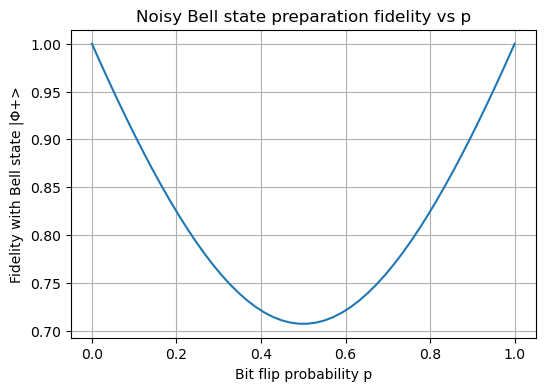

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# =========================
# Helper: basis vector |k>
# =========================
def basisvec(n, k):
    v = np.zeros(2**n, dtype=complex)
    v[k] = 1
    return v

# =========================
# Density matrix helper
# =========================
def pure_density(psi):
    psi = np.array(psi, dtype=complex).reshape(-1)
    return np.outer(psi, np.conj(psi))


# =========================
# Build sparse single qubit gate on n-qubit register
# =========================
def buildSparseGateSingle(n, i, gate):
    gate = sparse.csr_matrix(gate)
    left = sparse.identity(2**i, format="csr", dtype=complex)
    right = sparse.identity(2**(n-i-1), format="csr", dtype=complex)
    return sparse.kron(sparse.kron(left, gate), right)


# =========================
# Sparse CNOT builder
# =========================
def buildSparseCNOT(n, control, target):
    P0c = buildSparseGateSingle(n, control, P0)
    P1c = buildSparseGateSingle(n, control, P1)
    Xt  = buildSparseGateSingle(n, target, X)
    return P0c + P1c @ Xt

# =========================
# Embed 1-qubit Kraus ops into n-qubit register
# =========================
def kraus_on_register(n, i, kraus_ops_1q):
    embedded = []
    for E in kraus_ops_1q:
        E_full = buildSparseGateSingle(n, i, E).toarray()
        embedded.append(E_full)
    return embedded

# =========================
# Prepare Bell state density matrix (H0 + CNOT01)
# =========================
def prepare_bell_state_density():
    n = 2
    psi00 = basisvec(n, 0)
    rho = pure_density(psi00)

    # Apply H on qubit 0
    H0 = buildSparseGateSingle(n, 0, H).toarray()
    rho = H0 @ rho @ H0.conj().T

    # Apply CNOT(0->1)
    Ucnot = buildSparseCNOT(n, 0, 1).toarray()
    rho = Ucnot @ rho @ Ucnot.conj().T

    return rho

# =========================
# Perfect Bell state vector |Φ+>
# =========================
def bell_state_vector():
    psi00 = basisvec(2, 0)
    psi11 = basisvec(2, 3)
    return (psi00 + psi11) / np.sqrt(2)

# =========================
# Fidelity F = sqrt(<psi|rho|psi>)
# =========================
def fidelity_pure_target(rho, psi_target):
    val = np.vdot(psi_target, rho @ psi_target)
    return np.sqrt(np.real(val))

# =========================
# Noisy Bell preparation fidelity function
# =========================
def noisy_bell_fidelity(p):
    n = 2

    # perfect bell density after gates
    rho_bell = prepare_bell_state_density()

    # apply bit flip noise on qubit 0
    K0 = kraus_on_register(n, 0, bit_flip_kraus(p))
    rho_noisy = apply_kraus(rho_bell, K0)

    # apply bit flip noise on qubit 1
    K1 = kraus_on_register(n, 1, bit_flip_kraus(p))
    rho_noisy = apply_kraus(rho_noisy, K1)

    # fidelity with perfect bell
    psi_target = bell_state_vector()
    return fidelity_pure_target(rho_noisy, psi_target)

# =========================
# Plot Fidelity vs p
# =========================
ps = np.linspace(0, 1, 50)
Fs = [noisy_bell_fidelity(p) for p in ps]

plt.figure(figsize=(6,4))
plt.plot(ps, Fs)
plt.xlabel("Bit flip probability p")
plt.ylabel("Fidelity with Bell state |Φ+>")
plt.title("Noisy Bell state preparation fidelity vs p")
plt.grid(True)
plt.show()


In [52]:
# helper function for initializing all qubits in state zero
def initRegisterPsi(n):
    return basisvec(n,0)

def initRegisterRho(n):
    ini = basisvec(n,0)
    return np.outer(ini.conj(),ini)



### Problem 3: Simulating a quantum error correction protocol

We now come to the part of the assignment where we will implement an error correction code to the noisy state preparation. We assume perfect circuit elements and only apply error channels at certain points.

We will focus on the 3-qubit bit flip code.

#### (a) Error correction protocol

Simulate each step of the error correction protocol. In each step you should test that your code produces the expected outcome.

1) Encoding: Write a function that takes as an input a general single-qubit state. The output is the encoded state for the three qubit code space of the bit flip code and calculated by simulating the encoding circuit (the second and third qubit are initialized in state $|0\rangle$). You may assume that the input state is pure. 

2) Error: Write a function that applies the bit flip channel to all (three) qubits of the register.

3) Syndrome measurement: In order to perform the syndrome measurement you have to build the projectors $(P_0,P_1,P_2,P_3)$ onto the subspaces corresponding to different error syndromes, i.e., possible outcomes of the syndrome measurement. With these you can simulate the syndrome measurement using the function `doMeasurement()` provided below. Make sure you understand what it does.

4) Recovery: Apply the recovery operation corresponding to the detected syndrome, i.e., apply the channel $\mathcal{E}(\rho)=M_i \rho M_i^\dagger$ with $M_i = 1,X_1,X_2,X_3$, respectively, for the bit flip channel.

Optional: Do all of this for the phase flip code also!

The error correction protocol is not always successful, namely in the case where two or three errors occur. How does this manifest in the simulated protocol? Try different input states and different noise strengths.


In [57]:
import numpy as np

# ------------------------------------------------------------
# Helper: basis vector |k> in n qubits
def basisvec(n, k):
    v = np.zeros(2**n, dtype=complex)
    v[k] = 1
    return v


# ------------------------------------------------------------
# Helper: density matrix from pure state
def pure_density(psi):
    psi = np.array(psi, dtype=complex).reshape(-1)
    return np.outer(psi, np.conj(psi))


# ------------------------------------------------------------
# Your measurement function (given)
def doMeasurement(rho, projectors):
    pvec = [np.trace(rho @ pi) for pi in projectors]
    thresholds = np.cumsum(pvec)
    r = np.random.rand()
    indOutcome = np.sum(thresholds < r)
    postMeasState = projectors[indOutcome] @ rho @ projectors[indOutcome]
    return [indOutcome, postMeasState / pvec[indOutcome]]


# ------------------------------------------------------------
# Build n-qubit gate acting on qubit i
def buildGateSingle(n, i, gate):
    op = 1
    for q in range(n):
        if q == i:
            op = np.kron(op, gate)
        else:
            op = np.kron(op, np.eye(2))
    return op


# ------------------------------------------------------------
# Build n-qubit CNOT (control=ic, target=it)
def buildCNOT(n, ic, it):
    P0c = buildGateSingle(n, ic, P0)
    P1c = buildGateSingle(n, ic, P1)
    Xt  = buildGateSingle(n, it, X)
    return P0c + P1c @ Xt


# ------------------------------------------------------------
# (1) Encoding: |ψ> --> α|000> + β|111>
def encode_bitflip(psi):
    # psi = [alpha, beta]
    psi = np.array(psi, dtype=complex).reshape(2)

    # start state = |ψ> ⊗ |0> ⊗ |0>
    ket0 = np.array([1, 0], dtype=complex)
    psi3 = np.kron(np.kron(psi, ket0), ket0)

    # Apply CNOT(0->1) and CNOT(0->2)
    U01 = buildCNOT(3, 0, 1)
    U02 = buildCNOT(3, 0, 2)

    psi3 = U02 @ (U01 @ psi3)

    return psi3


# ------------------------------------------------------------
# (2) Apply bit flip noise to all 3 qubits (independent)
def apply_bitflip_noise_3qubits(rho3, p):
    kraus_1qubit = bit_flip_kraus(p)

    # Build Kraus ops for 3 qubits: Ek = E_a ⊗ E_b ⊗ E_c
    kraus_ops_3 = []
    for Ea in kraus_1qubit:
        for Eb in kraus_1qubit:
            for Ec in kraus_1qubit:
                kraus_ops_3.append(np.kron(np.kron(Ea, Eb), Ec))

    return apply_kraus(rho3, kraus_ops_3)


# ------------------------------------------------------------
# (3) Build syndrome projectors P0,P1,P2,P3
# For bit-flip code:
#   syndrome 00 -> no error
#   syndrome 01 -> error on qubit 2
#   syndrome 10 -> error on qubit 1
#   syndrome 11 -> error on qubit 0
def syndrome_projectors():
    # computational basis projectors for 3 qubits
    P = []
    for k in range(8):
        ket = basisvec(3, k)
        P.append(pure_density(ket))

    # Basis index mapping:
    # |000>=0 |001>=1 |010>=2 |011>=3 |100>=4 |101>=5 |110>=6 |111>=7

    # No error subspace: span{|000>,|111>}
    P0_syn = P[0] + P[7]

    # Error on qubit 0: span{|100>,|011>}
    P1_syn = P[4] + P[3]

    # Error on qubit 1: span{|010>,|101>}
    P2_syn = P[2] + P[5]

    # Error on qubit 2: span{|001>,|110>}
    P3_syn = P[1] + P[6]

    return [P0_syn, P1_syn, P2_syn, P3_syn]


# ------------------------------------------------------------
# (4) Recovery operation depending on syndrome
def recover_bitflip(rho_post, syndrome_index):
    # syndrome_index: 0=no error, 1=flip qubit0, 2=flip qubit1, 3=flip qubit2

    if syndrome_index == 0:
        Urec = np.eye(8)

    elif syndrome_index == 1:
        Urec = buildGateSingle(3, 0, X)

    elif syndrome_index == 2:
        Urec = buildGateSingle(3, 1, X)

    elif syndrome_index == 3:
        Urec = buildGateSingle(3, 2, X)

    return Urec @ rho_post @ Urec.conj().T


# ------------------------------------------------------------
# Full protocol: encode -> noise -> syndrome measurement -> recovery
def bitflip_error_correction_protocol(psi, p):
    # Encode
    psi_enc = encode_bitflip(psi)
    rho_enc = pure_density(psi_enc)

    # Apply noise
    rho_noisy = apply_bitflip_noise_3qubits(rho_enc, p)

    # Syndrome measurement
    projectors = syndrome_projectors()
    synd, rho_after_meas = doMeasurement(rho_noisy, projectors)

    # Recovery
    rho_recovered = recover_bitflip(rho_after_meas, synd)

    return synd, rho_enc, rho_noisy, rho_recovered


# ------------------------------------------------------------
# ✅ TEST EXAMPLE
# Choose input single qubit state |ψ> = (|0> + |1>)/sqrt(2)
psi = (1/np.sqrt(2)) * np.array([1, 1], dtype=complex)

p = 0.2
syndrome, rho_encoded, rho_noisy, rho_corrected = bitflip_error_correction_protocol(psi, p)


print("Syndrome outcome =", syndrome)
print("Encoded state density matrix shape:", rho_encoded.shape)
print("Noisy state density matrix shape:", rho_noisy.shape)
print("Corrected state density matrix shape:", rho_corrected.shape)


Syndrome outcome = 0
Encoded state density matrix shape: (8, 8)
Noisy state density matrix shape: (8, 8)
Corrected state density matrix shape: (8, 8)


#### (b) Analyzing the performance of the error correction protocol

Use the state obtained by applying the error channel to study the average performance (success rate) of the error correction propotcol and compare it to the case where no error correction is applied: Write a loop that perform the error correction protocol (syndrome measurement and recovery) multiple times. Each time the simulation of the measurement will provide random outcomes.

Calculate the average fidelity over many runs, i.e., the fidelity between the errror corrected state and the encoded state before the error channel.

Compare this to the non-corrected fidelity, i.e., the fidelity between the initial single qubit input state and the state after applying the error channel to this qubit.

How much does the error correction protocol improve the fidelity? How does this depend on the error probability $p$? It will also depend on the input state! Recall that there are states that are not affected at all by the bit flip channel. Can the error corrected fidelity be worse than the uncorrected one?

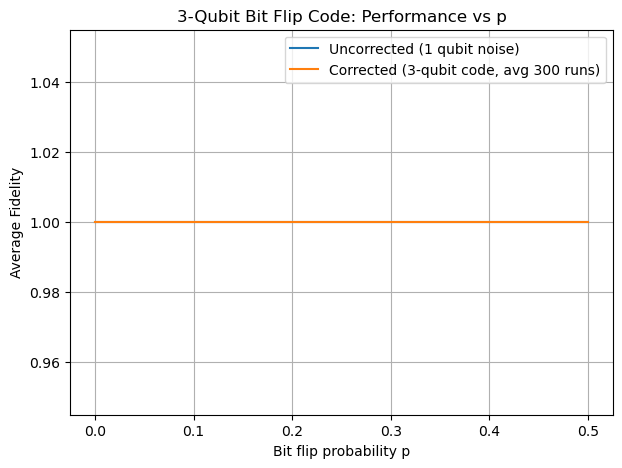

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# ======================================
# 1) Helper: basis vector |k> in n qubits
# ======================================
def basisvec(n, k):
    v = np.zeros(2**n, dtype=complex)
    v[k] = 1
    return v

# ======================================
# 2) Pure density matrix from |psi>
# ======================================
def pure_density(psi):
    psi = np.array(psi, dtype=complex).reshape(-1)
    return np.outer(psi, np.conj(psi))

# ======================================
# 3) Build X acting on qubit i in n qubits
# ======================================
def kron_n(ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

I2 = np.eye(2, dtype=complex)
X1 = np.array([[0, 1],
               [1, 0]], dtype=complex)

def X_on_qubit(n, i):
    ops = []
    for q in range(n):
        ops.append(X1 if q == i else I2)
    return kron_n(ops)

# ======================================
# 4) Encoding: |psi> -> alpha|000> + beta|111>
# ======================================
def encode_bitflip_code(psi):
    alpha, beta = psi[0], psi[1]
    psi_enc = alpha * basisvec(3, 0) + beta * basisvec(3, 7)   # |000> + |111>
    return pure_density(psi_enc)

# ======================================
# 5) Bit-flip noise channel on 1 qubit (Kraus)
# ======================================
def bit_flip_kraus(p):
    E0 = np.sqrt(1-p) * I2
    E1 = np.sqrt(p)   * X1
    return [E0, E1]

def apply_kraus(rho, kraus_ops):
    out = np.zeros_like(rho, dtype=complex)
    for E in kraus_ops:
        out += E @ rho @ E.conj().T
    return out

# ======================================
# 6) Apply bit-flip noise to ALL 3 qubits
# ======================================
def apply_bitflip_noise_all_qubits(rho, p):
    # Kraus for each qubit expanded into 3 qubits
    kraus_1 = bit_flip_kraus(p)

    # build tensor-product Kraus list
    full_kraus = []
    for E0 in kraus_1:
        for E1 in kraus_1:
            for E2 in kraus_1:
                full_kraus.append(np.kron(np.kron(E0, E1), E2))

    return apply_kraus(rho, full_kraus)

# ======================================
# 7) Syndrome projectors P0,P1,P2,P3
#    based on which qubit flipped
# ======================================
def syndrome_projectors():
    # code space: {|000>, |111>}
    # error on qubit 1: {|100>,|011>}
    # error on qubit 2: {|010>,|101>}
    # error on qubit 3: {|001>,|110>}

    code0 = pure_density(basisvec(3,0)) + pure_density(basisvec(3,7))
    err1  = pure_density(basisvec(3,4)) + pure_density(basisvec(3,3))
    err2  = pure_density(basisvec(3,2)) + pure_density(basisvec(3,5))
    err3  = pure_density(basisvec(3,1)) + pure_density(basisvec(3,6))

    return [code0, err1, err2, err3]

# ======================================
# 8) Measurement function (given by sheet)
# ======================================
def doMeasurement(rho, projectors):
    pvec = [np.real(np.trace(rho @ pi)) for pi in projectors]
    thresholds = np.cumsum(pvec)
    r = np.random.rand()
    indOutcome = np.sum(thresholds < r)
    postMeasState = projectors[indOutcome] @ rho @ projectors[indOutcome]
    return indOutcome, postMeasState / pvec[indOutcome]

# ======================================
# 9) Recovery based on syndrome outcome
# ======================================
def apply_recovery(rho, syndrome):
    # syndrome:
    # 0 = no error
    # 1 = flip on qubit 0
    # 2 = flip on qubit 1
    # 3 = flip on qubit 2
    if syndrome == 0:
        return rho
    elif syndrome == 1:
        return X_on_qubit(3,0) @ rho @ X_on_qubit(3,0)
    elif syndrome == 2:
        return X_on_qubit(3,1) @ rho @ X_on_qubit(3,1)
    elif syndrome == 3:
        return X_on_qubit(3,2) @ rho @ X_on_qubit(3,2)

# ======================================
# 10) Fidelity with encoded reference (pure-ish)
# ======================================
def fidelity_encoded(rho_ref, rho_test):
    return np.sqrt(np.real(np.trace(rho_ref @ rho_test)))

# ======================================
# 11) Fidelity for uncorrected single qubit
# ======================================
def fidelity_pure_target(rho, psi):
    return np.sqrt(np.real(np.conj(psi) @ (rho @ psi)))

def uncorrected_fidelity(p, psi):
    rho1 = pure_density(psi)
    rho1_noisy = apply_kraus(rho1, bit_flip_kraus(p))
    return fidelity_pure_target(rho1_noisy, psi)

# ======================================
# 12) Average corrected fidelity (Monte Carlo)
# ======================================
def avg_corrected_fidelity(p, psi, n_runs=200):

    rho_enc = encode_bitflip_code(psi)                 # encoded target
    rho_noisy = apply_bitflip_noise_all_qubits(rho_enc, p)

    proj_list = syndrome_projectors()

    Fs = []
    for _ in range(n_runs):
        outcome, rho_post = doMeasurement(rho_noisy, proj_list)
        rho_corr = apply_recovery(rho_post, outcome)
        Fs.append(fidelity_encoded(rho_enc, rho_corr))

    return np.mean(Fs)

# ======================================
# 13) RUN + PLOT
# ======================================
psi = (1/np.sqrt(2)) * np.array([1, 1], dtype=complex)   # |+>

ps = np.linspace(0, 0.5, 25)
n_runs = 300

F_uncorr = []
F_corr = []

for p in ps:
    F_uncorr.append(uncorrected_fidelity(p, psi))
    F_corr.append(avg_corrected_fidelity(p, psi, n_runs=n_runs))

plt.figure(figsize=(7,5))
plt.plot(ps, F_uncorr, label="Uncorrected (1 qubit noise)")
plt.plot(ps, F_corr, label=f"Corrected (3-qubit code, avg {n_runs} runs)")
plt.xlabel("Bit flip probability p")
plt.ylabel("Average Fidelity")
plt.title("3-Qubit Bit Flip Code: Performance vs p")
plt.grid(True)
plt.legend()
plt.show()
